# 5.¿Cómo  se  distribuyen  las  especies  fósiles  en las regiones de chile según  sus  hábitos alimenticios, y qué nos puede decir esto sobre la estructura ecológica de la región en diferentes períodos geológicos?

### 1. Importación y preparación de datos

In [98]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
import os
import seaborn as sns

In [99]:
# Cargar el dataset principal ya limpio
chile_df = pd.read_csv('data_clean/chile_clean.csv')

# Verificar las columnas disponibles para decidir qué usar
print("Columnas en el dataset principal:", chile_df.columns)

Columnas en el dataset principal: Index(['species_name', 'occurrence_no', 'accepted_name', 'phylum', 'class',
       'order', 'family', 'genus', 'lat', 'lng', 'diet', 'life_habit',
       'environment', 'taxon_environment', 'primary_name', 'era_early',
       'era_late'],
      dtype='object')


In [100]:
# Seleccionar columnas relevantes para el análisis
columns_to_use = ['diet', 'lat', 'lng', 'era_early', 'era_late']
df_diet = chile_df[columns_to_use]

In [101]:
# Copiar los datos seleccionados para trabajar
df_diet = df_diet.copy()

# Filtrar valores nulos en coordenadas (latitud y longitud)
df_diet = df_diet[df_diet['lat'].notnull() & df_diet['lng'].notnull()]

# Crear geometrías a partir de las coordenadas
geometry = [Point(xy) for xy in zip(df_diet['lng'], df_diet['lat'])]
chile_geo_df = gpd.GeoDataFrame(df_diet, geometry=geometry, crs="EPSG:4326")

In [102]:
df_diet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9481 entries, 0 to 9480
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   diet       8749 non-null   object 
 1   lat        9481 non-null   float64
 2   lng        9481 non-null   float64
 3   era_early  9481 non-null   object 
 4   era_late   9481 non-null   object 
dtypes: float64(2), object(3)
memory usage: 370.5+ KB


No se eliminaran las filas que tienen valores nulos en las dietas, ya que se reducian como 700 lineas, las caules nos pueden ayudar en la distribucion de fosiles por era.

In [103]:
# Ver los valores únicos en la columna 'diet'.
unique_diets = df_diet['diet'].unique()
print(unique_diets)

# Ver también la cantidad de veces que aparece cada valor.
diet_counts = df_diet['diet'].value_counts()
print(diet_counts)

['deposit feeder, suspension feeder' 'deposit feeder' 'suspension feeder'
 'grazer' 'chemosymbiotic' 'chemosymbiotic, suspension feeder' 'omnivore'
 'carnivore' nan 'herbivore' 'microcarnivore, photosymbiotic'
 '"photoautotroph"' 'C3 autotroph' 'photosymbiotic, suspension feeder'
 'detritivore' 'insectivore' 'omnivore, grazer' 'grazer, carnivore'
 'piscivore, carnivore' 'piscivore' 'browser' 'grazer, browser'
 'carnivore, omnivore' 'frugivore, folivore'
 'carnivore, suspension feeder' 'deposit feeder, detritivore'
 'microcarnivore' 'grazer, deposit feeder'
 'detritivore, suspension feeder' 'carnivore, detritivore'
 'grazer, omnivore' 'durophage, carnivore' 'durophage, piscivore'
 'frugivore' 'herbivore, carnivore' 'suspension feeder, detritivore'
 'suspension feeder, carnivore' 'insectivore, carnivore' 'browser, grazer'
 'frugivore, granivore' 'insectivore, frugivore' 'granivore'
 'carnivore, parasite' 'browser, browser']
diet
suspension feeder                    4666
carnivore        

In [104]:
# Cargar los shapefiles de regiones y comunas
gdf_regiones = gpd.read_file(r'data/Regiones/Regional.shp').to_crs("EPSG:4326")
gdf_comunas = gpd.read_file(r'data/Comunas_chile/comunas.shp').to_crs("EPSG:4326")

# Hacer la unión espacial para agregar información de regiones al GeoDataFrame
chile_geo_df = gpd.sjoin(chile_geo_df, gdf_regiones, how='inner', predicate='within')

# Verificar las primeras filas del GeoDataFrame
print("Primeras filas del GeoDataFrame procesado:")
print(chile_geo_df.head())

Primeras filas del GeoDataFrame procesado:
                                diet   lat   lng   era_early         era_late  \
0  deposit feeder, suspension feeder -37.0 -73.0  Cretaceous  No especificado   
1  deposit feeder, suspension feeder -37.0 -73.0  Cretaceous  No especificado   
2  deposit feeder, suspension feeder -37.0 -73.0  Cretaceous  No especificado   
3                     deposit feeder -37.0 -73.0  Cretaceous  No especificado   
4                     deposit feeder -37.0 -73.0  Cretaceous  No especificado   

          geometry  index_right  objectid  cir_sena  codregion       area_km  \
0  POINT (-73 -37)           12      1096        10          8  24021.621594   
1  POINT (-73 -37)           12      1096        10          8  24021.621594   
2  POINT (-73 -37)           12      1096        10          8  24021.621594   
3  POINT (-73 -37)           12      1096        10          8  24021.621594   
4  POINT (-73 -37)           12      1096        10          8  24021.

# 2. Limpieza y análisis descriptivo

### Lógica de Agrupación por dieta.
1. Filtros y Suspensores:
    -   Agrupa organismos que obtienen su alimento del agua o sedimentos mediante filtración o suspensión. Esto incluye aquellos que pueden tener características de alimentación tanto de depósitos como de suspensión.
2. Consumidores Primarios:
    -    Incluye organismos que se alimentan directamente de productores (plantas, algas) o fuentes primarias de alimento. Son generalmente herbívoros y se agrupan por su dieta de materia vegetal o frutas.
3. Consumidores Secundarios (Carnívoros):
    -    Comprende los organismos que se alimentan de otros animales. Esta categoría incluye varios tipos de carnívoros, desde depredadores generales hasta especializados (como piscívoros, que se alimentan de peces).
4. Omnívoros:
    -    Agrupa organismos que consumen tanto materia vegetal como animal. Esta categoría puede incluir aquellos que tienen dietas variadas y que no se limitan a un solo tipo de alimento.
5. Descomponedores y Detritívoros:
    -    Incluye organismos que se alimentan de materia orgánica en descomposición. Los detritívoros son esenciales para el reciclaje de nutrientes en los ecosistemas.
6. Simbiontes y Especializados:
    -    Agrupa organismos que tienen relaciones simbióticas o que dependen de procesos biológicos específicos para su alimentación, como los que obtienen energía a través de reacciones químicas (quimiosíntesis).
7. Otros Combinados:
    -    Incluye aquellos organismos que tienen dietas mixtas que no se ajustan claramente a las categorías anteriores. Estos pueden ser carnívoros que también consumen material vegetal o viceversa.

In [105]:
# Listas de estrategias alimentarias
filtros_y_suspensores = [
    'deposit feeder, suspension feeder',
    'suspension feeder',
    'photosymbiotic, suspension feeder',
    'detritivore, suspension feeder',
    'carnivore, suspension feeder'
]

consumidores_primarios = [
    'grazer',
    'herbivore',
    'frugivore',
    'granivore',
    'browser',
    'browser, grazer'
]

consumidores_secundarios = [
    'carnivore',
    'microcarnivore',
    'piscivore',
    'insectivore',
    'durophage, carnivore',
    'insectivore, carnivore',
    'carnivore, omnivore',
    'carnivore, parasite'
]

omnivoros = [
    'omnivore',
    'omnivore, grazer',
    'herbivore, carnivore',
    'frugivore, folivore',
    'grazer, omnivore'
]

descomponedores_y_detritivoros = [
    'detritivore',
    'deposit feeder, detritivore',
    'grazer, deposit feeder',
    'detritivore, suspension feeder'
]

simbiontes_y_especializados = [
    'chemosymbiotic',
    'chemosymbiotic, suspension feeder',
    'microcarnivore, photosymbiotic',
    '"photoautotroph"',
    'C3 autotroph'
]

#Lo agrego mejor a omnivoros?
otros_combinados = [
    'grazer, carnivore',
    'piscivore, carnivore',
    'durophage, piscivore',
    'insectivore, frugivore'
]

In [106]:
def categorize_diet(diet):
    if pd.isna(diet):
        return 'incertidumbre'
    
    diet = diet.lower()
    
    categories = {
        'filtros y suspensores': filtros_y_suspensores,
        'consumidores primarios': consumidores_primarios,
        'consumidores secundarios': consumidores_secundarios,
        'omnivoros': omnivoros,
        'descomponedores y detritívoros': descomponedores_y_detritivoros,
        'simbiontes y especializados': simbiontes_y_especializados,
        'otros combinados': otros_combinados,
    }
    
    for category, items in categories.items():
        if diet in items:
            return category
    
    return 'otros'


In [107]:
# Aplicar la categorización al DataFrame
chile_geo_df['diet_grouped'] = chile_geo_df['diet'].apply(categorize_diet)
# Verificar las agrupaciones
print("Conteo por grupos de dieta:")
print(chile_geo_df['diet_grouped'].value_counts())


Conteo por grupos de dieta:
diet_grouped
filtros y suspensores             4718
consumidores secundarios          2183
incertidumbre                      707
consumidores primarios             502
simbiontes y especializados        323
omnivoros                          319
otros                              148
descomponedores y detritívoros      50
otros combinados                    33
Name: count, dtype: int64


# 3. Visualización geográfica

## Mapeo por dieta en Chile:

In [108]:
def mapear_dietas(df_diet, gdf_comunas, columna_dieta='diet_grouped', titulo="Distribución de Dietas en Chile"):
    # Filtrar datos con coordenadas válidas
    df_diet = df_diet[df_diet['lat'].notnull() & df_diet['lng'].notnull()]
    geometry = [Point(xy) for xy in zip(df_diet['lng'], df_diet['lat'])]
    
    # Crear GeoDataFrame
    chile_geo_df = gpd.GeoDataFrame(df_diet, geometry=geometry, crs="EPSG:4326")
    colores = {
        'filtros y suspensores': 'blue',
        'consumidores primarios': 'green',
        'consumidores secundarios': 'red',
        'omnivoros': 'orange',
        'descomponedores y detritívoros': 'purple',
        'simbiontes y especializados': 'cyan',
        'otros combinados': 'magenta'
    }

    # Configuración de colores
    if colores is None:
        categorias = chile_geo_df[columna_dieta].unique()
        colores = {cat: plt.cm.get_cmap('tab20')(i / len(categorias)) for i, cat in enumerate(categorias)}
    
    # Crear el gráfico
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    gdf_comunas.plot(ax=ax, color='lightgrey', edgecolor='black')  # Fondo de las comunas

    for dieta, color in colores.items():
        subset = chile_geo_df[chile_geo_df[columna_dieta] == dieta]
        if not subset.empty:  # Evitar errores con conjuntos vacíos
            subset.plot(ax=ax, color=color, markersize=10, label=dieta, alpha=0.6)
    
    # Ajustes visuales
    ax.set_aspect('equal')
    plt.legend(title=columna_dieta, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(titulo, fontsize=16)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.show()


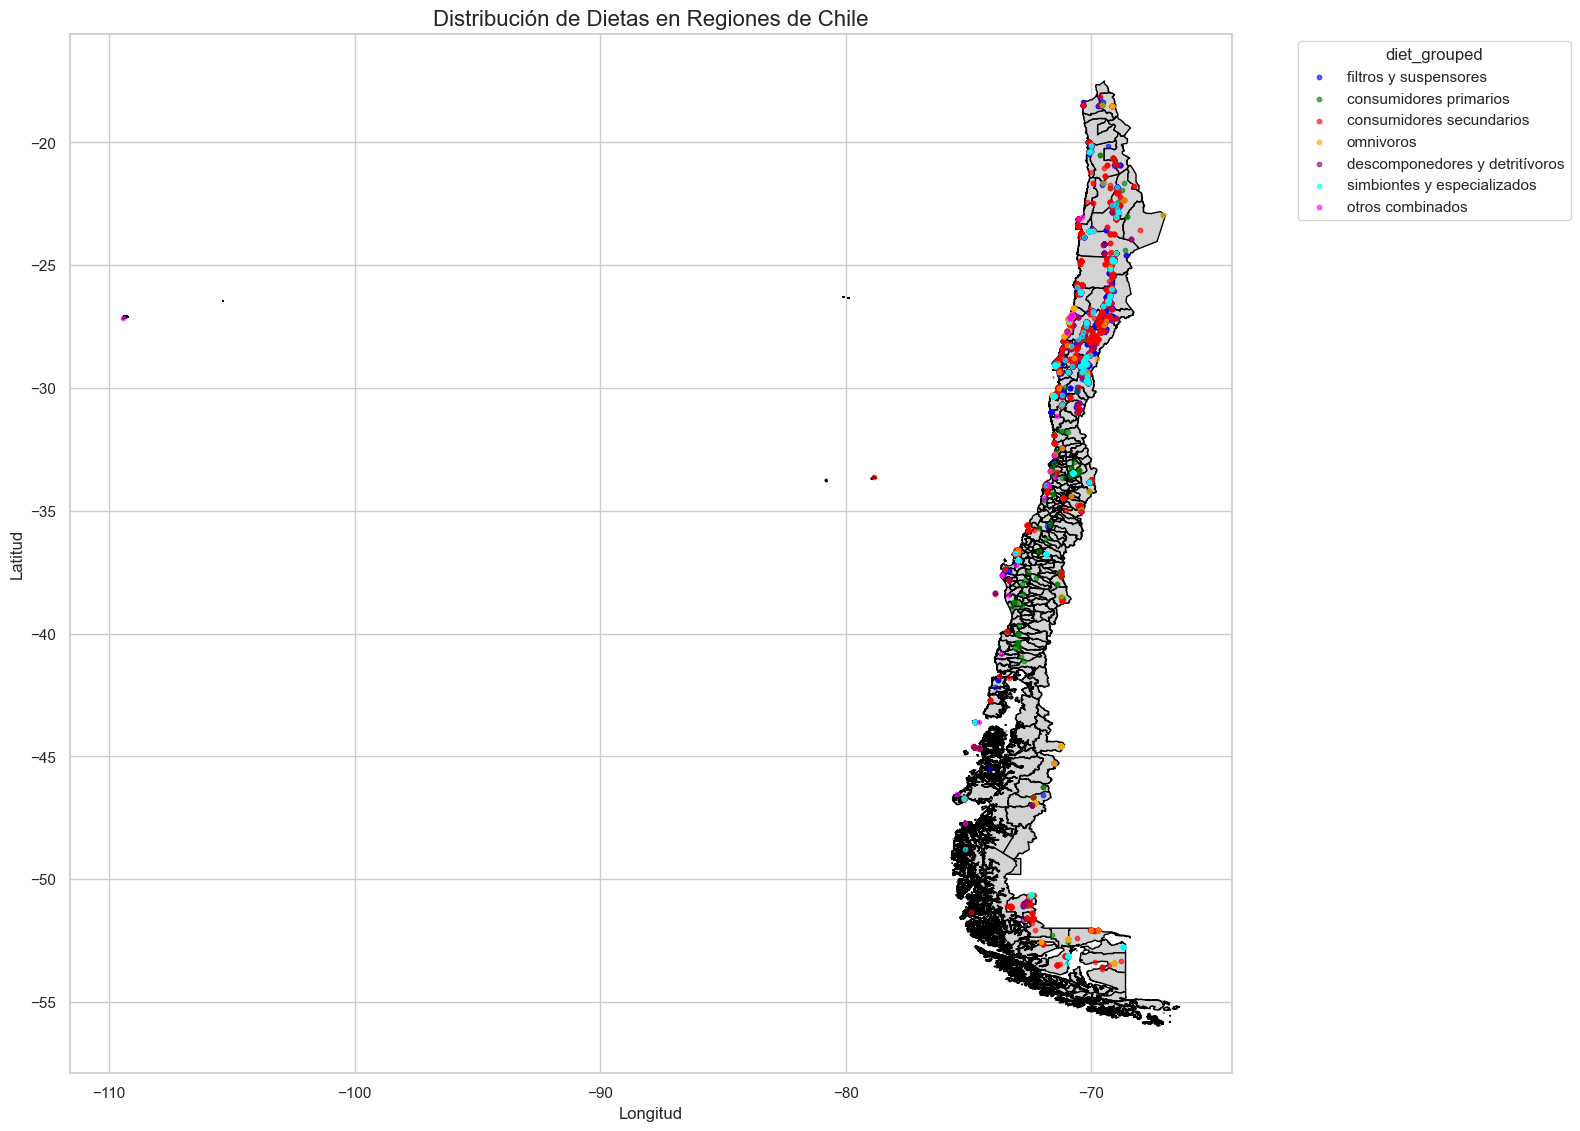

In [109]:
# Llamar a la función para graficar el mapa con las dietas
mapear_dietas(chile_geo_df, gdf_comunas,'diet_grouped',"Distribución de Dietas en Regiones de Chile")

### Mapear por regiones especificas de Chile:

In [110]:
def plot_regions_and_communes(region_names, gdf_regiones, gdf_comunas, chile_geo_df):
    regions_shape = gdf_regiones[gdf_regiones['Region'].isin(region_names)]
    comunas_shape = gdf_comunas[gdf_comunas['Region'].isin(region_names)]
    regions_fossils = chile_geo_df[chile_geo_df['Region'].isin(region_names)]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    regions_shape.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
    comunas_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)
    
    colors = {
        'filtros y suspensores': 'blue',
        'consumidores primarios': 'green',
        'consumidores secundarios': 'red',
        'omnivoros': 'orange',
        'descomponedores y detritívoros': 'purple',
        'simbiontes y especializados': 'cyan',
        'otros combinados': 'magenta',
    }
    
    for diet, color in colors.items():
        subset = regions_fossils[regions_fossils['diet_grouped'] == diet]
        if not subset.empty:
            subset.plot(ax=ax, color=color, markersize=10, label=diet, alpha=0.6)
    
    plt.legend()
    plt.title(f"Fósiles por habito alimenticio en la Región {region_names}", fontsize=14)
    plt.show()


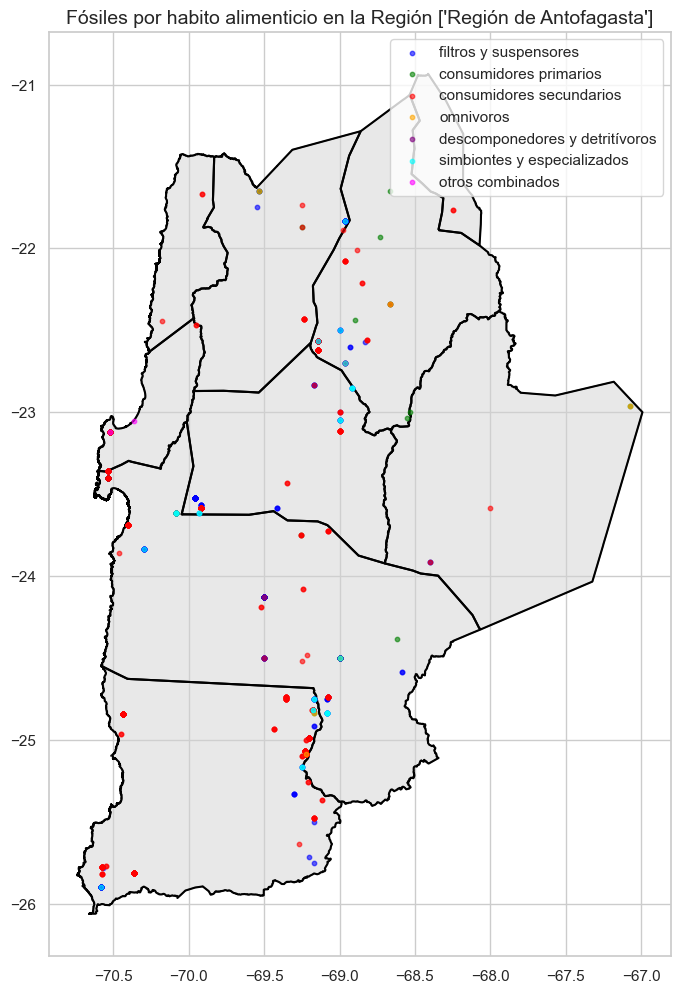

In [111]:
plot_regions_and_communes(['Región de Antofagasta'], gdf_regiones, gdf_comunas, chile_geo_df)

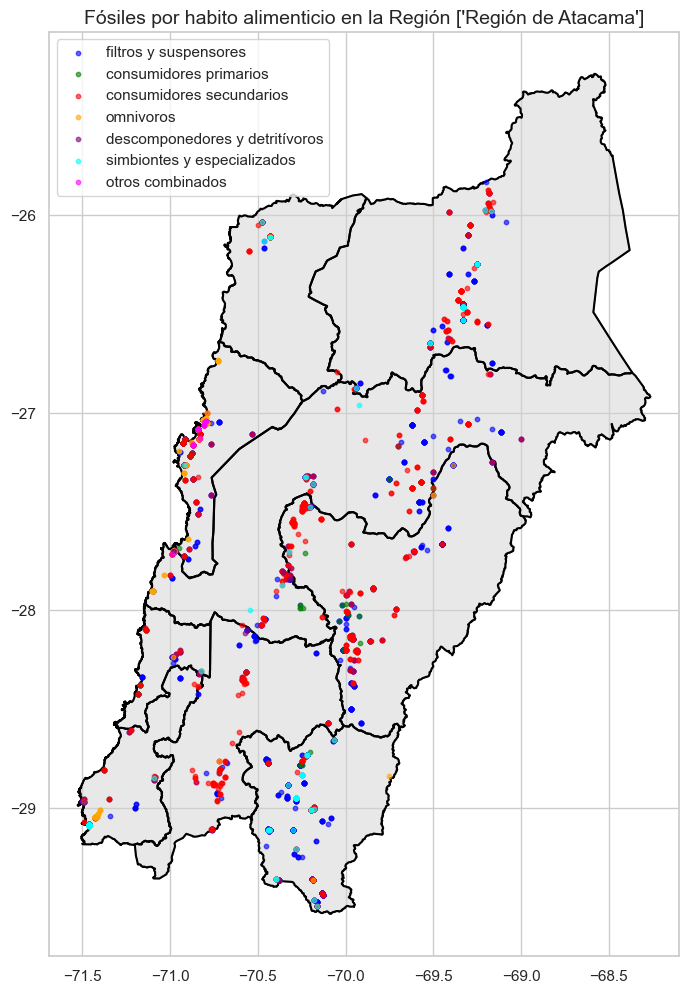

In [112]:

plot_regions_and_communes(['Región de Atacama'], gdf_regiones, gdf_comunas, chile_geo_df)

### Fósiles agrupados por dieta

In [113]:
def plot_diet_distribution(df, title="Distribución de Dietas"):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, y='diet_grouped', order=df['diet_grouped'].value_counts().index, palette="viridis")
    plt.title(title)
    plt.xlabel("Cantidad de Fósiles")
    plt.ylabel("Grupo de Dietas")
    plt.show()

C:\Users\FZ6\AppData\Local\Temp\ipykernel_5352\2026075114.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='diet_grouped', order=df['diet_grouped'].value_counts().index, palette="viridis")


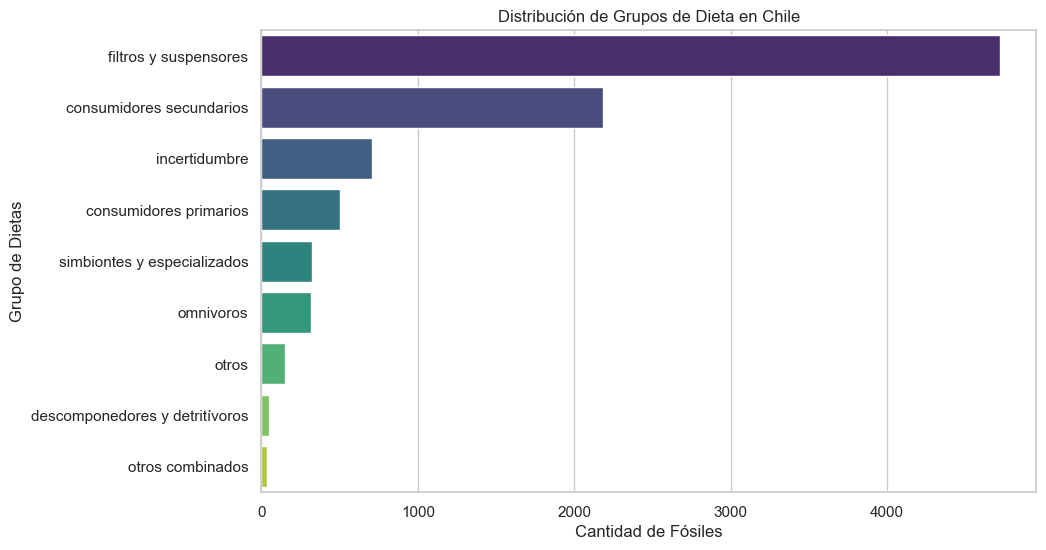

In [114]:
# Distribución de Dietas
plot_diet_distribution(chile_geo_df, "Distribución de Grupos de Dieta en Chile")


# Mapear por era

In [115]:

def plot_fossils_by_era(region_name, gdf_regiones, gdf_comunas, chile_geo_df, top_n=5):
    """
    Gráfica fósiles en una región agrupados por las épocas más representativas y añade las comunas.
    """
    region_shape = gdf_regiones[gdf_regiones['Region'] == region_name]
    if region_shape.empty:
        print(f"La región '{region_name}' no existe en el shapefile.")
        return
    
    region_fossils = chile_geo_df[chile_geo_df['Region'] == region_name]
    top_eras = region_fossils.groupby('era_early')['diet'].nunique().nlargest(top_n)
    print(f"Top {top_n} épocas con más especies únicas en la región {region_name}:")
    print(top_eras)
    
    filtered_fossils = region_fossils[region_fossils['era_early'].isin(top_eras.index)]

    # Configurar el gráfico
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    region_shape.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)
    
    comunas_shape = gdf_comunas[gdf_comunas['Region'] == region_name]
    comunas_shape.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)
    # Definir colores fijos para cada era
    fixed_colors = {
        'Cretaceous': 'orange',
        'Neogene': 'green',
        'Paleogene': 'blue',
        'Jurassic': 'red',
        'Triassic': 'purple',
        'Permian': 'cyan',
        'Carboniferous': 'magenta',
        # Agrega más eras y colores según sea necesario
    }
    # Graficar fósiles por época usando colores fijos
    for era in top_eras.index:
        subset = filtered_fossils[filtered_fossils['era_early'] == era]
        if era in fixed_colors:
            color = fixed_colors[era]
        else:
            color = 'black'  # Color por defecto si la era no está en el diccionario
        subset.plot(ax=ax, color=color, markersize=12, label=era, alpha=0.8)
    
    plt.legend(title="Época", loc='upper right')
    plt.title(f"Fósiles por Época en la Región {region_name}", fontsize=14)
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.show()

def plot_fossils_by_era_in_zones(zones, gdf_regiones, gdf_comunas, chile_geo_df, top_n=5):
    """
    Graficar fósiles en zonas (Norte, Centro, Sur) agrupados por épocas más representativas.
    """
    for zone in zones:
        for region in zone:
            print(f"Graficando para la región: {region}")
            plot_fossils_by_era(region, gdf_regiones, gdf_comunas, chile_geo_df, top_n)

In [116]:
# Clasificar las regiones en Norte, Centro y Sur
norte = [
    'Región de Arica y Parinacota',
    'Región de Tarapacá',
    'Región de Antofagasta',
    'Región de Atacama',
    'Región de Coquimbo'
]

centro = [
    'Región de Valparaíso',
    'Región Metropolitana de Santiago',
    "Región del Libertador Bernardo O'Higgins",
    'Región del Maule',
    'Región de Ñuble',
    'Región del Bío-Bío'
]

sur = [
    'Región de La Araucanía',
    'Región de Los Ríos',
    'Región de Los Lagos',
    'Región de Aysén del Gral. Ibañez del Campo',
    'Región de Magallanes y Antártica Chilena'
]

In [117]:
# Llamar a la función para graficar fósiles por era en las zonas Norte, Centro y Sur (mostrara cada region!)
#plot_fossils_by_era_in_zones([norte], gdf_regiones, gdf_comunas, chile_geo_df, top_n=5)

### Fósiles agrupados por era

In [118]:
# Función para graficar fósiles agrupados por era
def plot_era_distribution(df, title="Distribución de Fósiles por Era"):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='era_early', kde=False, bins=20, color='skyblue')
    plt.title(title)
    plt.xlabel("Era (Millones de Años)")
    plt.ylabel("Cantidad de Fósiles")
    plt.show()

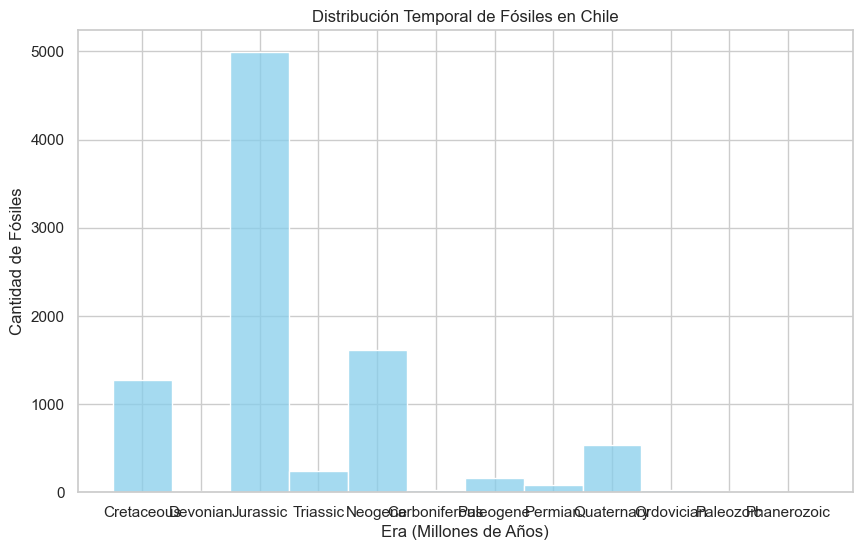

In [119]:
#Distribución de Fósiles por Era
plot_era_distribution(chile_geo_df, "Distribución Temporal de Fósiles en Chile")

# 4. Clustering K-means

¿Por qué usar Clustering?
El clustering es adecuado en situaciones en las que no se tienen etiquetas para los datos y se desea explorar la estructura subyacente del conjunto de datos. En lugar de asignar etiquetas a los datos (como en el aprendizaje supervisado), el clustering intenta descubrir grupos o patrones en los datos de manera autónoma.

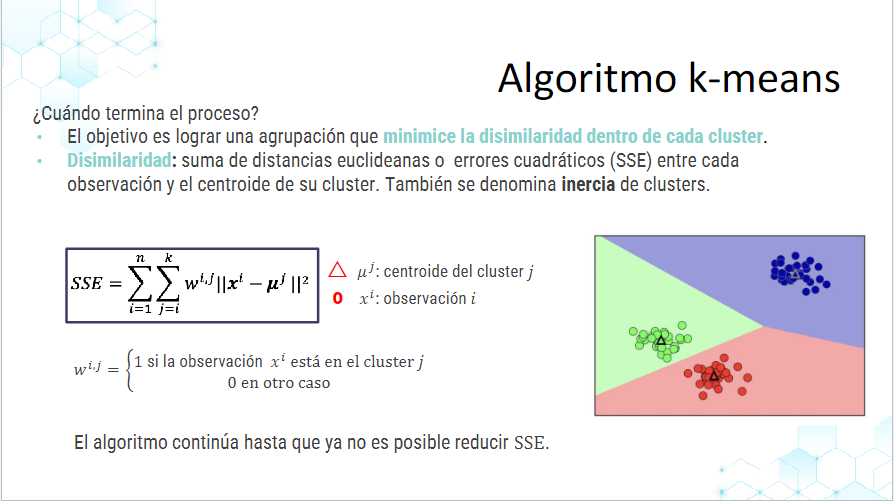

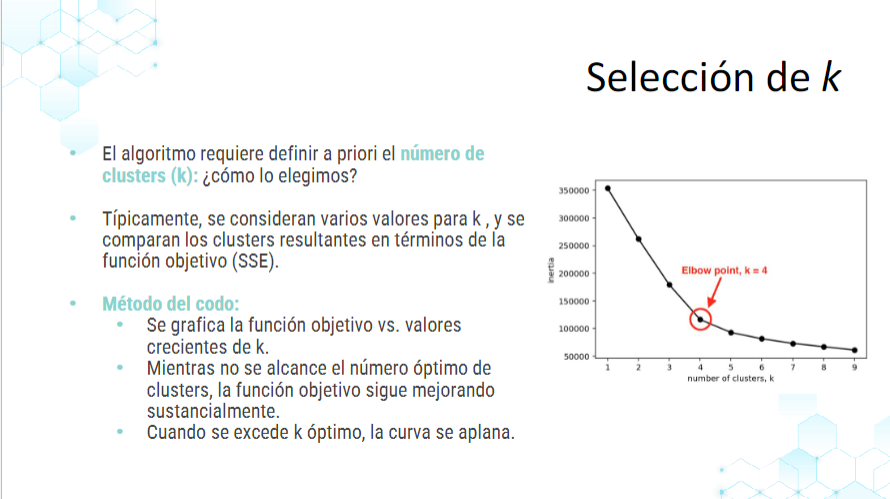

Agrupar fósiles por ubicación geográfica: Encontrar zonas con alta concentración de fósiles. Ayuda a identificar áreas geográficas con patrones similares de fósiles, tal vez correlacionadas con ciertas eras o tipos de dieta.

Agrupar fósiles por era y dieta: Si las dietas de los fósiles están relacionadas con ciertas eras, el clustering ayuda a identificar subgrupos dentro de cada era o dieta. Esto te permitiría explorar la distribución de las especies sin necesidad de definir las categorías a priori.

Encontrar patrones en las dietas: Si tienes información sobre las dietas y las eras, el clustering podría ayudar a agrupar las dietas similares entre sí, tal vez encontrando nuevas relaciones que no habías considerado antes.

#### Normalización de las coordenadas geográficas: Sistema EPSG:4326 (latitud y longitud)

## Clustering para la distribución geográfica de los fósiles

Aquí usamos las coordenadas geográficas (lat, lng) para identificar patrones de distribución espacial. Este tipo de clustering permite observar:

Áreas donde los fósiles están más concentrados.

Diferenciación entre regiones basadas en las ubicaciones de los fósile

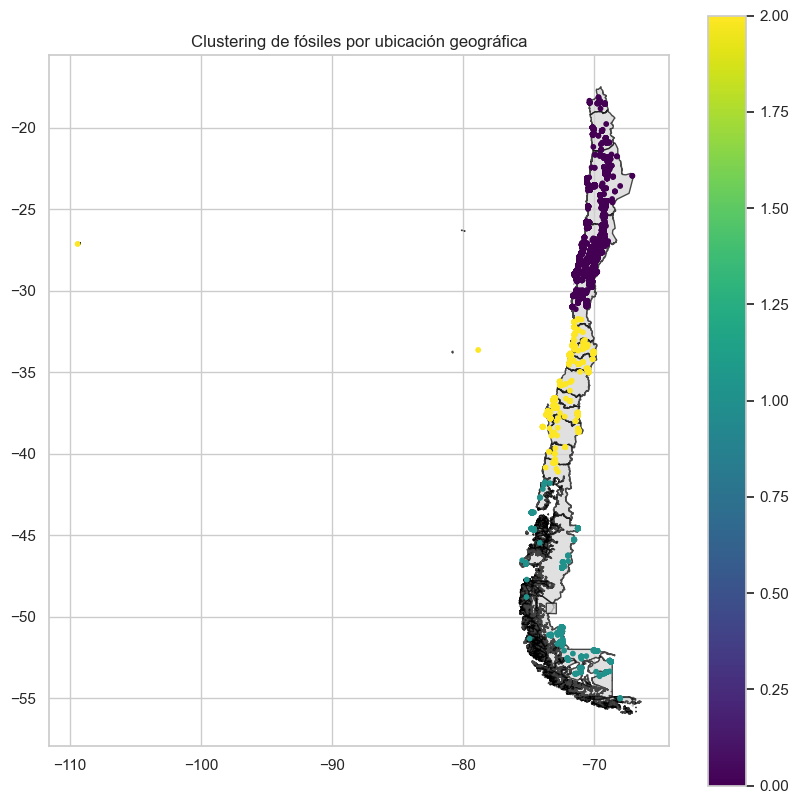

In [ ]:
coordinates = chile_geo_df[['lat', 'lng']]

# Crear el modelo K-means
kmeans = KMeans(n_clusters=3)  # Número de clústeres
chile_geo_df['cluster'] = kmeans.fit_predict(coordinates)

# Visualizar los resultados
fig, ax = plt.subplots(figsize=(10, 10))
gdf_regiones.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)
chile_geo_df.plot(ax=ax, column='cluster', cmap='viridis', markersize=10, legend=True)
plt.title("Clustering de fósiles por ubicación geográfica")
plt.show()

# Clustering DBSCAN

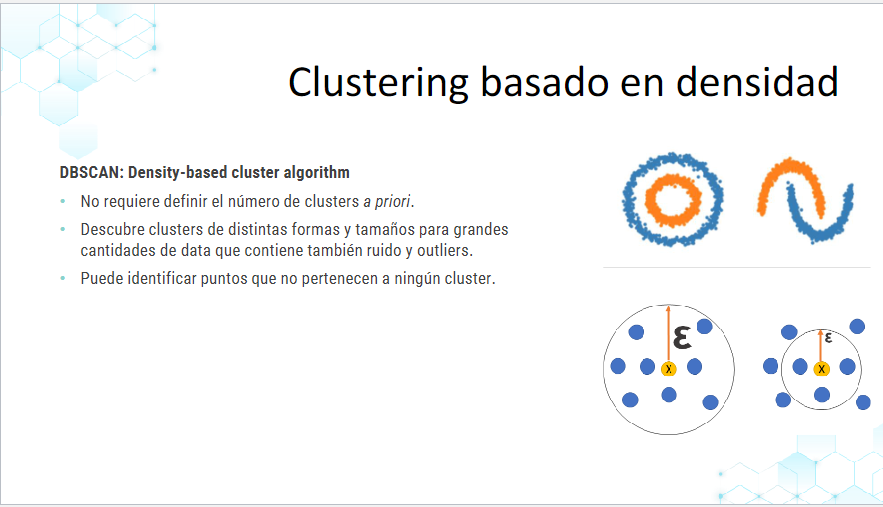

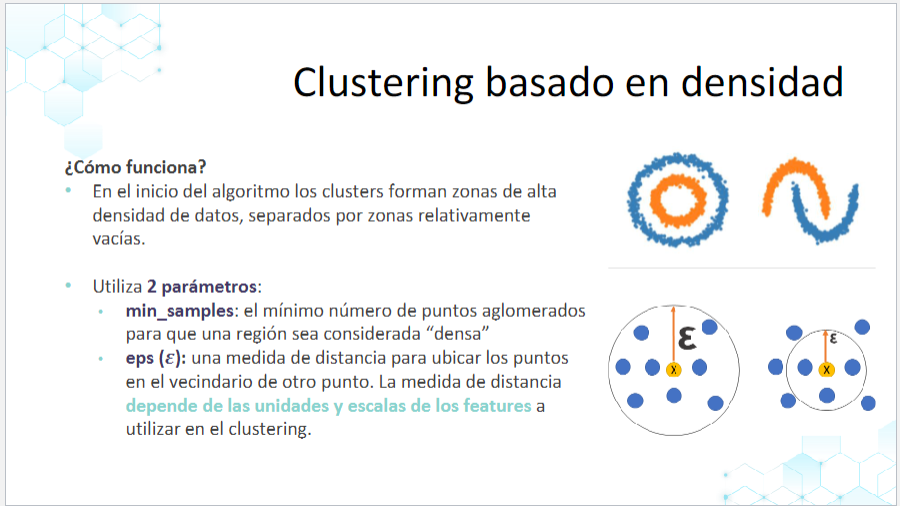

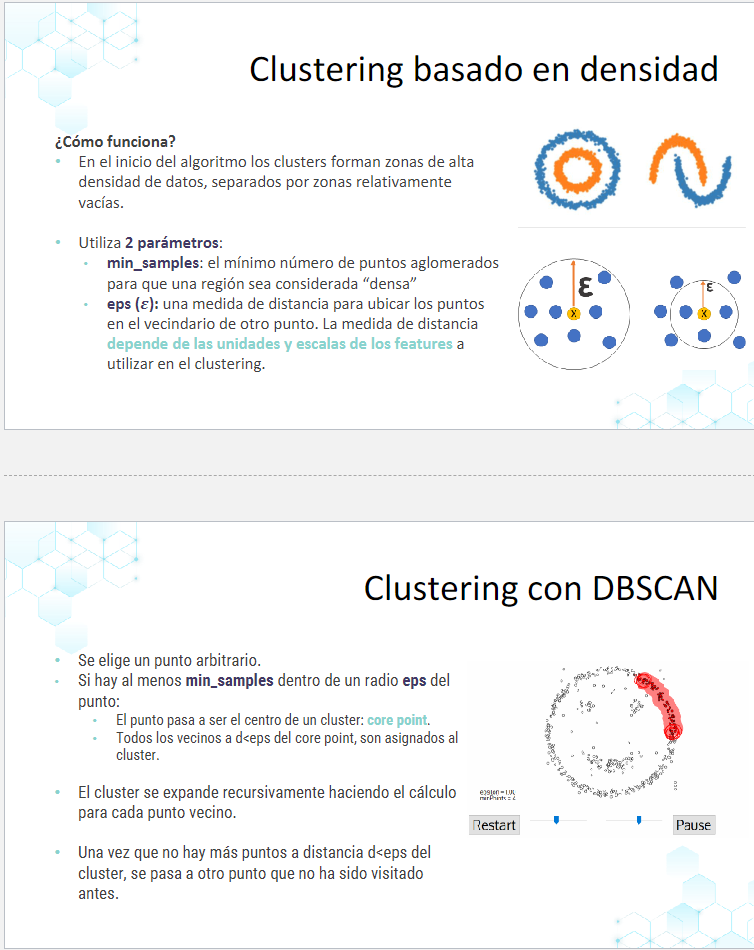

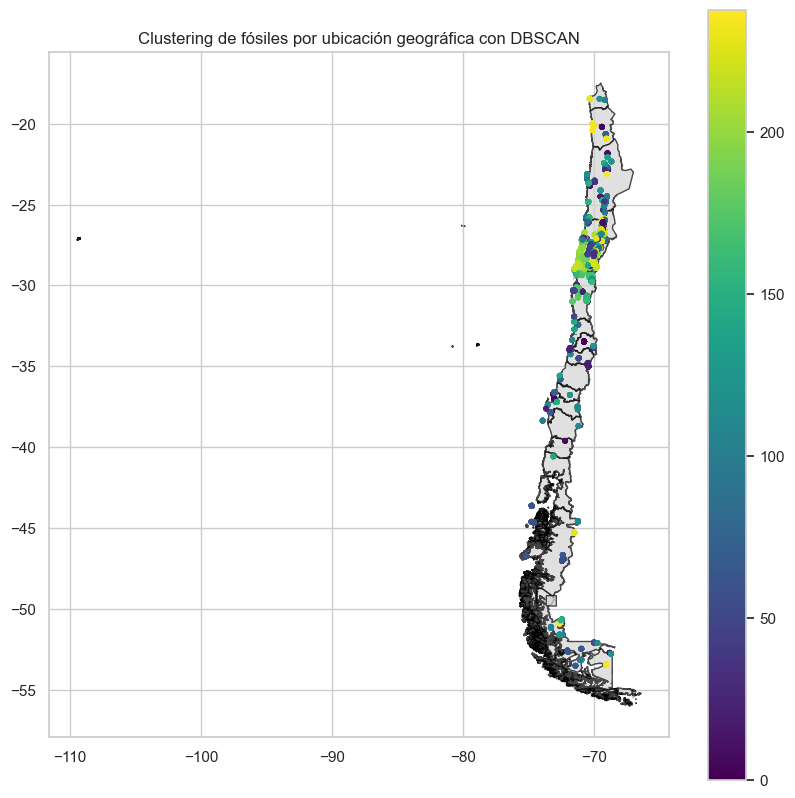

In [ ]:
from sklearn.cluster import DBSCAN

# Usamos las coordenadas lat y lng
coordinates = chile_geo_df[['lat', 'lng']].to_numpy()

# DBSCAN con distancia de 0.01 grados (ajusta según la escala de tus datos)
dbscan = DBSCAN(eps=0.0450, min_samples=5)  # eps es la distancia máxima entre dos puntos para considerarlos parte del mismo clúster
chile_geo_df['dbscan_cluster'] = dbscan.fit_predict(coordinates)

# Visualizar los resultados
fig, ax = plt.subplots(figsize=(10, 10))
gdf_regiones.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7)
chile_geo_df[chile_geo_df['dbscan_cluster'] != -1].plot(ax=ax, column='dbscan_cluster', cmap='viridis', markersize=10, legend=True)
plt.title("Clustering de fósiles por ubicación geográfica con DBSCAN")
plt.show()


¿Cómo elegir el valor de eps?
El valor de eps debe ser seleccionado de forma que:

Sea adecuado para las distancias geográficas en Chile.
Permita que el algoritmo agrupe los puntos de manera efectiva, sin que se agrupe demasiado o que se designe como ruido.

¿Cómo calcular eps?
Una forma de determinar eps es calcular la distancia en kilómetros entre dos puntos cercanos, usando las coordenadas geográficas.

La distancia geográfica se puede calcular utilizando la fórmula de Haversine, que calcula la distancia entre dos puntos en la superficie de una esfera (en este caso, la Tierra) dado su latitud y longitud.

Ejemplo para calcular eps en DBSCAN
Supongamos que deseas que eps corresponda a una distancia de 5 kilómetros (que es razonable para agrupar puntos geográficos cercanos). Primero, convertimos la distancia deseada de kilómetros a grados de latitud y longitud.

1. Convertir distancias geográficas a grados
En la superficie de la Tierra, aproximadamente:

1 grado de latitud ≈ 111 km.
1 grado de longitud ≈ 111 km * cos(latitud) (la longitud varía según la latitud).
Por lo tanto, si quieres que eps cubra aproximadamente 5 km, se puede calcular el valor de eps en grados.

In [123]:
# Convertimos la distancia deseada (5 km) en grados (latitud y longitud)
# Aproximadamente 1 grado = 111 km

# Distancia en km
distancia_km = 5

# Convertimos a grados
distancia_grados = distancia_km / 111  # Aproximadamente 0.045 grados

print(f"Distancia en grados (aprox. 5 km): {distancia_grados:.4f}")


Distancia en grados (aprox. 5 km): 0.0450


## Clustering por dieta

Por grupos actuales

Clustering basado en características geoespaciales y dietas:
Si tienes tanto la información de la dieta como las coordenadas geográficas (latitud y longitud), puedes hacer un clustering espacial de los fósiles, y luego analizar si la dieta influye en el agrupamiento.

Para esto, podrías usar algoritmos como:

DBSCAN (Density-Based Spatial Clustering of Applications with Noise): Ideal para encontrar clústeres de alta densidad en áreas geográficas.
KMeans: Si prefieres un enfoque más general de clustering que no se base en la densidad, puedes probarlo. Sin embargo, KMeans requiere que el número de clústeres sea determinado previamente, lo cual puede no ser tan flexible como DBSCAN.

    lat   lng  diet_encoded  diet_cluster
0 -37.0 -73.0             3             2
1 -37.0 -73.0             3             2
2 -37.0 -73.0             3             2
3 -37.0 -73.0             6             2
4 -37.0 -73.0             6             2


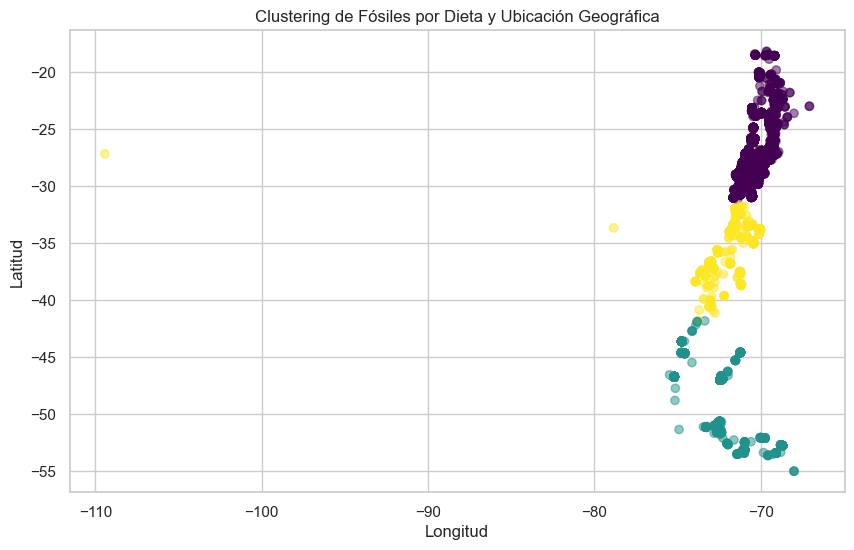

In [124]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Asumimos que chile_geo_df ya tiene la columna 'diet_grouped' con las dietas categorizadas
# Convertir las dietas en valores numéricos
label_encoder = LabelEncoder()
chile_geo_df['diet_encoded'] = label_encoder.fit_transform(chile_geo_df['diet_grouped'])

# Ahora, puedes hacer clustering con KMeans usando 'diet_encoded' y otras características (como latitud y longitud)
# Para simplificar, haremos clustering con latitud, longitud y dieta
X = chile_geo_df[['lat', 'lng', 'diet_encoded']]

# Hacer el clustering con KMeans
kmeans = KMeans(n_clusters=3, random_state=0)  # Proponemos 3 clusters como ejemplo
chile_geo_df['diet_cluster'] = kmeans.fit_predict(X)

# Verificar los resultados
print(chile_geo_df[['lat', 'lng', 'diet_encoded', 'diet_cluster']].head())

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(chile_geo_df['lng'], chile_geo_df['lat'], c=chile_geo_df['diet_cluster'], cmap='viridis', alpha=0.5)
plt.title('Clustering de Fósiles por Dieta y Ubicación Geográfica')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()


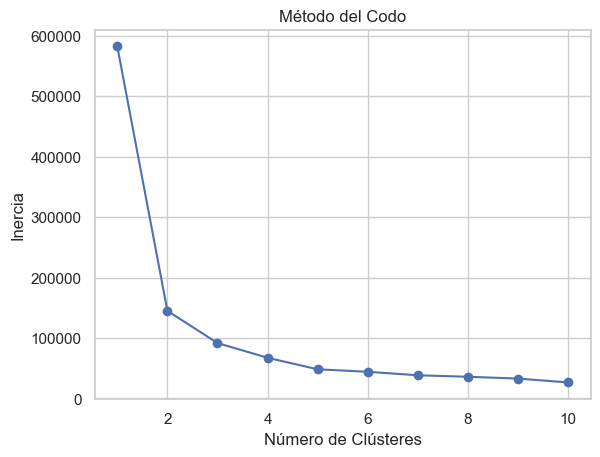

In [125]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determinar el número adecuado de clústeres
inertia = []
for k in range(1, 11):  # Probar con k de 1 a 10
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.show()


Inercia: Mide cuán compactos están los clústeres. Una inercia más baja indica que los puntos dentro de cada clúster están más cerca del centroide.

Número de clústeres: Indica la cantidad de grupos que estás considerando.

El "codo" es el punto donde la disminución de la inercia se hace menos pronunciada, lo que significa que agregar más clústeres no mejora significativamente la compactación. En el gráfico, parece que el codo está en 3 clústeres, lo que indica que este es el número óptimo de grupos para los datos.

Reduciendo los grupos:

In [127]:
# Agrupar las dietas en tres categorías
def categorize_diet(diet):
    if diet in ['filtros y suspensores', 'consumidores primarios']:
        return 'Herbívoro'
    elif diet in ['consumidores secundarios', 'omnivoros']:
        return 'Omnívoro'
    else:
        return 'Carnívoro'

chile_geo_df['diet_category'] = chile_geo_df['diet_grouped'].apply(categorize_diet)


In [130]:
# Revisar la proporción de categorías de dieta por clúster
cluster_analysis = chile_geo_df.groupby('geo_diet_cluster')['diet_category'].value_counts(normalize=True)
print(cluster_analysis)


geo_diet_cluster  diet_category
0                 Omnívoro         0.423930
                  Herbívoro        0.299525
                  Carnívoro        0.276545
1                 Herbívoro        0.645097
                  Omnívoro         0.250880
                  Carnívoro        0.104023
2                 Herbívoro        0.527872
                  Omnívoro         0.276182
                  Carnívoro        0.195946
Name: proportion, dtype: float64


Análisis por clúster:
Clúster 0:

Omnívoro: 42.39% (predomina).
Herbívoro: 29.95%.
Carnívoro: 27.65%.
Este clúster está asociado principalmente con fósiles de Omnívoros, pero tiene una distribución relativamente balanceada.

Clúster 1:

Herbívoro: 64.51% (predomina).
Omnívoro: 25.09%.
Carnívoro: 10.40%.
Este clúster está dominado por fósiles de Herbívoros.

Clúster 2:

Herbívoro: 52.78% (predomina).
Omnívoro: 27.62%.
Carnívoro: 19.59%.

Este clúster está mayormente asociado con fósiles de Herbívoros, aunque hay una proporción significativa de Omnívoros.

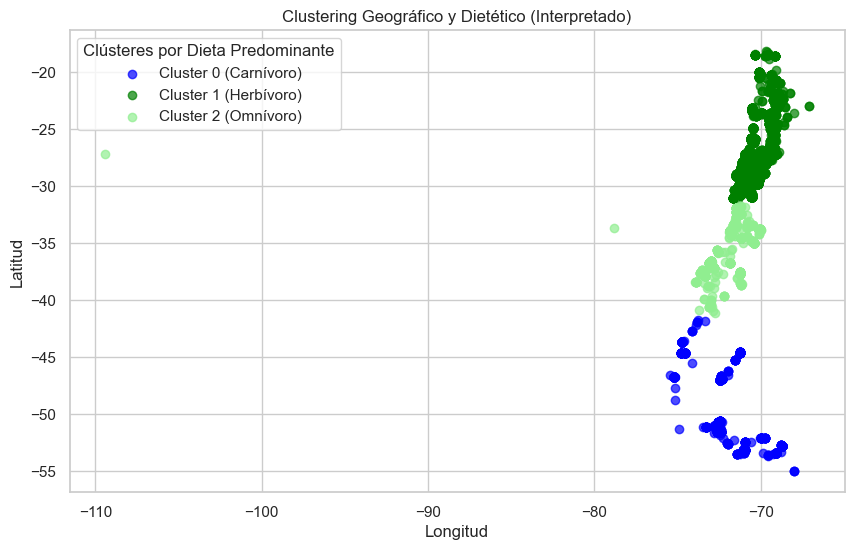

In [131]:
# Asignar colores interpretativos a cada clúster según su dieta predominante
cluster_colors = {
    0: 'blue',      # Omnívoros
    1: 'green',     # Herbívoros (dominante)
    2: 'lightgreen' # Herbívoros (más mixto)
}

# Graficar con los colores interpretativos
plt.figure(figsize=(10, 6))
for cluster, color in cluster_colors.items():
    subset = chile_geo_df[chile_geo_df['geo_diet_cluster'] == cluster]
    plt.scatter(
        subset['lng'], subset['lat'], 
        c=color, label=f'Cluster {cluster} ({label_encoder.inverse_transform([cluster])[0]})', 
        alpha=0.7
    )

plt.title('Clustering Geográfico y Dietético (Interpretado)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend(title="Clústeres por Dieta Predominante")
plt.show()


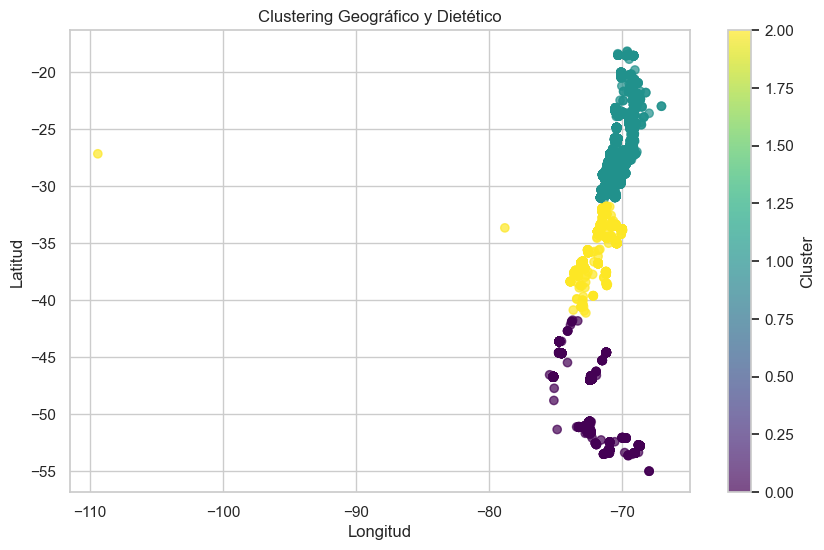

In [ ]:
#lo mismo pero sin leyenda

# Codificar las categorías de dieta
label_encoder = LabelEncoder()
chile_geo_df['diet_encoded'] = label_encoder.fit_transform(chile_geo_df['diet_category'])

# Crear un conjunto de datos con coordenadas geográficas y dietas
X = chile_geo_df[['lat', 'lng', 'diet_encoded']]

# Aplicar KMeans con el número óptimo de clústeres (3, según el codo)
kmeans = KMeans(n_clusters=3, random_state=42)
chile_geo_df['geo_diet_cluster'] = kmeans.fit_predict(X)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(chile_geo_df['lng'], chile_geo_df['lat'], c=chile_geo_df['geo_diet_cluster'], cmap='viridis', alpha=0.7)
plt.title('Clustering Geográfico y Dietético')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.colorbar(label='Cluster')
plt.show()


Resultados esperados
Grupos visibles en el mapa: El gráfico mostrará cómo los fósiles se agrupan según las categorías de dieta y su ubicación geográfica. Cada clúster tendrá un color diferente.


# 5. Análisis de distribuciones

# Resultados y conclusiones
